# Final evaluation of model paths

In [1]:
cafe = "cafe"
pgpr = "pgpr"
models = [cafe, pgpr]
pgpr_flavors = ["no_entropy", "low_entropy", "medium_entropy", "high_entropy", "rel_entropy"]
all_relations = ["created_by", "has_micro_genre", "has_genre", "in_album", "listened_to"]

dataset = "lfm"

In [2]:
from random import seed, randint, choice
from collections import defaultdict
import pickle
import numpy as np

### Some basic evaluation functions

In [3]:
def dcg_at_k(topk, k, method=1):
    topk = np.asfarray(topk)[:k]
    if topk.size:
        if method == 0:
            return topk[0] + np.sum(topk[1:] / np.log2(np.arange(2, topk.size + 1)))
        elif method == 1:
            return np.sum(topk / np.log2(np.arange(2, topk.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.

def ndcg_at_k(topk, k, method=1):
    dcg_max = dcg_at_k(sorted(topk, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(topk, k, method) / dcg_max

def recall_at_k(topk, test_pids):
    return sum(topk) / len(test_pids)
    
def precision_at_k(topk, k):
    return sum(topk) / k

In [4]:
def path_len(path):
    len = 0
    for s in path:
        if type(s) != str:
            s = str(s)
        if s.isnumeric():
            len+=1
    return len

# Path Structure: user 5038 watched product 2430 watched user 1498 watched product 1788
def template(curr_model, path):
    if path[0] == "self_loop":
        path = path[1:]

    path_length = path_len(path)
    for i in range(1, len(path)):
        s = str(path[i])
        if s.isnumeric():
            if path[i-1] == 'user': continue
            if int(path[i]) not in entity2name[curr_model][path[i-1]]: continue
            path[i] = entity2name[curr_model][path[i-1]][int(path[i])]
    if path_length == 4:
        _, uid, rel_0, e_type_1, e_1, rel_1, e_type_2, e_2, rel_k, _, pid  = path
        return f"{pid} is recommend to you because you {rel_0} {e_1} also {rel_k} by {e_2}"
    elif path_len(path) == 3:
        _, uid, rel_0, e_type_1, e_1, rel_1, _, pid  = path
        return f"{pid} is recommend to you because is {r_k} with {e_1} that you previously {rel_0}"

In [5]:
from knowledge_graph_utils import entity2plain_text
entity2name = {}
entity2name["cafe"] = entity2plain_text(dataset, "cafe")
entity2name["pgpr"] = entity2plain_text(dataset, "pgpr")

### Load train and test labels for each model

In [6]:
train_labels = {}
test_labels = {}

In [7]:
model_name = "pgpr"
%cd models/PGPR
from pgpr_utils import load_labels

train_labels[model_name] = load_labels(dataset, 'train')
test_labels[model_name] = load_labels(dataset, 'test')
%cd ../..


/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src/models/PGPR
/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src


In [8]:
model_name = "cafe"
%cd models/CAFE

from cafe_utils import load_labels

train_labels[model_name] = load_labels(dataset, 'train')
test_labels[model_name] = load_labels(dataset, 'test')
%cd ../..

/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src/models/CAFE
/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src


In [9]:
def load_paths(model, flavor):
    if flavor != "" and flavor is not None:
        with open(f"results/lfm/{model}/{flavor}/pred_paths.pkl", 'rb') as pred_paths_file:
            paths = pickle.load(pred_paths_file)
    else:
        with open(f"results/lfm/{model}/pred_paths.pkl", 'rb') as pred_paths_file:
            paths = pickle.load(pred_paths_file)
    pred_paths_file.close()
    
    pred_paths_map = defaultdict(dict)
    for record in paths:
        uid, pid, path_score, path_prob, path = record
        if pid not in pred_paths_map[uid]:
            pred_paths_map[uid][pid] = []
        pred_paths_map[uid][pid].append((float(path_score), float(path_prob), path))
    return pred_paths_map

In [10]:
def select_best_paths(pred_paths_map, model):
    best_pred_paths = {}
    for uid in pred_paths_map:
        if uid in train_labels[model]:
            train_pids = set(train_labels[model][uid])
        else:
            print("Invalid train_pids")
        best_pred_paths[uid] = []
        for pid in pred_paths_map[uid]:
            if pid in train_pids:
                continue
            # Get the path with highest probability
            sorted_path = sorted(pred_paths_map[uid][pid], key=lambda x: x[1], reverse=True)
            best_pred_paths[uid].append(sorted_path[0])
    return best_pred_paths

In [11]:
def paths_for_top_k(model, best_paths, k):
    users_topk = defaultdict(list)
    if model == "pgpr":
        for uid in range(len(best_paths.keys())):
            sorted_paths = sorted(best_paths[uid], key=lambda x: (x[0], x[1]), reverse=True)
            sorted_paths = [[path[0], path[1], path[-1].split(" ")] for path in sorted_paths]
            topk_products = [int(path[-1][-1]) for path in sorted_paths[:k]]
            topk_explanations = [path[-1] for path in sorted_paths[:k]]
            users_topk[uid] = list(zip(topk_products, topk_explanations))
    elif model == "cafe":
        for uid, pids in best_paths.items():
            user_paths = []
            for paths in pids.values():
                user_paths.extend(paths)
            sorted(user_paths, key=lambda x: x[0], reverse=True)
            users_topk[uid] = [(path[-1][-1], path[-1]) for path in user_paths[:k]]
    return users_topk

In [12]:
def metrics_for_top_k(user_topk, model):
    ndcgs = []
    recalls = []
    precisions = []
    for uid, rec_exp_tuples in user_topk.items():
        hits = []
        for rec_exp_tuple in rec_exp_tuples:
            recommended_pid = rec_exp_tuple[0]
            if recommended_pid in test_labels[model][uid]:
                hits.append(1)
            else:
                hits.append(0)
        while len(hits) < 10:
            hits.append(0)
        ndcg = ndcg_at_k(hits, k)
        precision = precision_at_k(hits, k)
        recall = recall_at_k(hits, test_labels[model][uid])
        ndcgs.append(ndcg)
        precisions.append(precision)
        recalls.append(recall)
    print(f"Overall NDGC: {np.mean(ndcgs)}, Precision: {np.mean(precisions)}, Recall: {np.mean(recalls)}")
    return float(np.mean(ndcgs)), float(np.mean(precisions)), float(np.mean(recalls))

## Evaluate basic path properties

In [13]:
k = 10
topk_paths = {}

In [14]:
model_name = "pgpr"

In [15]:
for flavor in pgpr_flavors:
    print(flavor)
    pred_paths_map_pgpr = load_paths(model_name, flavor)
    best_paths = select_best_paths(pred_paths_map_pgpr, model_name)
    topk_paths[model_name + "_" + flavor] = paths_for_top_k(model_name, best_paths, k)
    metrics_for_top_k(topk_paths[model_name + "_" + flavor], model_name)

no_entropy
Overall NDGC: 0.08425451474999626, Precision: 0.020676890534108937, Recall: 0.002391528964855994
low_entropy
Overall NDGC: 0.08523186123650602, Precision: 0.020719196192490748, Recall: 0.0023271944439544234
medium_entropy
Overall NDGC: 0.08444170200201206, Precision: 0.020782654680063458, Recall: 0.00232221117987114
high_entropy
Overall NDGC: 0.08335732295552584, Precision: 0.020676890534108937, Recall: 0.002312046307972717
rel_entropy
Overall NDGC: 0.0780655005681122, Precision: 0.01807509254362771, Recall: 0.0018974226577077105


In [16]:
def count_relations(user_topk, model):
    relation_counts = []
    for user in user_topk:
        relations = {}
        for relation_name in all_relations:
            relations[relation_name] = 0
        item_count = len(user_topk[user])
        for i in range(item_count):
            relation_index = 6 if model == "pgpr" else 5
            relation = user_topk[user][i][1][relation_index]
            if relation == "rev_listened":
                relation = "listened_to"
            relations[relation] += 1/item_count
        relation_counts.append(relations)
    
    average_relations = {}
    for relation_name in all_relations:
        average_relations[relation_name] = sum(r[relation_name] for r in relation_counts) / len(user_topk)

    return average_relations

In [17]:
relation_counts = {}

In [18]:
for flavor in pgpr_flavors:
    print(flavor)
    relation_counts[model_name + "_" + flavor] = count_relations(topk_paths[model_name + "_" + flavor], model_name)

no_entropy
low_entropy
medium_entropy
high_entropy
rel_entropy


In [50]:
topk_paths["pgpr_medium_entropy"][0]

[(169533,
  ['self_loop',
   'user',
   '0',
   'listened_to',
   'product',
   '21960',
   'listened_to',
   'user',
   '2512',
   'listened_to',
   'product',
   '169533']),
 (166370,
  ['self_loop',
   'user',
   '0',
   'listened_to',
   'product',
   '61981',
   'listened_to',
   'user',
   '2955',
   'listened_to',
   'product',
   '166370']),
 (169005,
  ['self_loop',
   'user',
   '0',
   'listened_to',
   'product',
   '40520',
   'listened_to',
   'user',
   '9296',
   'listened_to',
   'product',
   '169005']),
 (171479,
  ['self_loop',
   'user',
   '0',
   'listened_to',
   'product',
   '55566',
   'listened_to',
   'user',
   '3914',
   'listened_to',
   'product',
   '171479']),
 (169679,
  ['self_loop',
   'user',
   '0',
   'listened_to',
   'product',
   '63380',
   'listened_to',
   'user',
   '7284',
   'listened_to',
   'product',
   '169679']),
 (171411,
  ['self_loop',
   'user',
   '0',
   'listened_to',
   'product',
   '61981',
   'listened_to',
   'user',
  

In [19]:
model_name = "cafe"

predicted_paths = load_paths(model_name, None)
topk_paths[model_name]  = paths_for_top_k(model_name, predicted_paths, k)
relation_counts[model_name] = count_relations(topk_paths[model_name], model_name)
metrics_for_top_k(topk_paths[model_name], model_name)


Overall NDGC: 0.07641083248013784, Precision: 0.01965097831835008, Recall: 0.003043877015559237


(0.07641083248013784, 0.01965097831835008, 0.003043877015559237)

In [20]:
relation_counts[model_name]

{'created_by': 0.008466168064264331,
 'has_micro_genre': 0.3187818656459844,
 'has_genre': 0.14512956107879205,
 'in_album': 0.0054517220249637385,
 'listened_to': 0.5221706831860203}

In [21]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sns.set() 

In [22]:
pd.DataFrame(relation_counts)

,pgpr_no_entropy,pgpr_low_entropy,pgpr_medium_entropy,pgpr_high_entropy,pgpr_rel_entropy,cafe
created_by,0.000539,0.000423,0.000497,0.000518,0.003987,0.008466
has_micro_genre,0.023184,0.022210,0.021861,0.022760,0.244326,0.318782
has_genre,0.000804,0.000740,0.000740,0.000465,0.041111,0.145130
in_album,0.001015,0.000867,0.001036,0.000910,0.002750,0.005452
listened_to,0.974458,0.975759,0.975865,0.975346,0.707827,0.522171


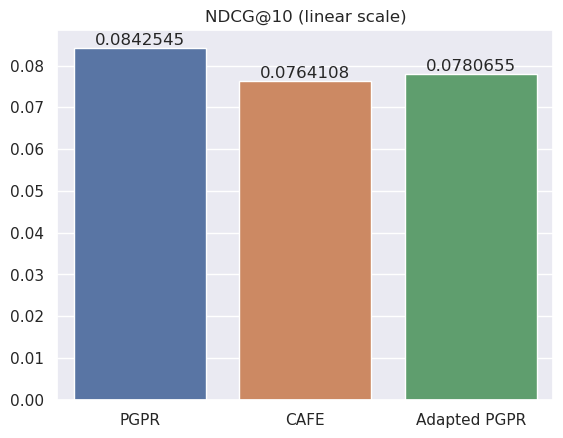

In [23]:
plt.figure()
ax = sns.barplot(x=["PGPR", "CAFE", "Adapted PGPR"], y=[0.08425451474999626,0.07641083248013784, 0.0780655005681122])
plt.title("NDCG@10 (linear scale)")
for i in ax.containers:
    ax.bar_label(i,)

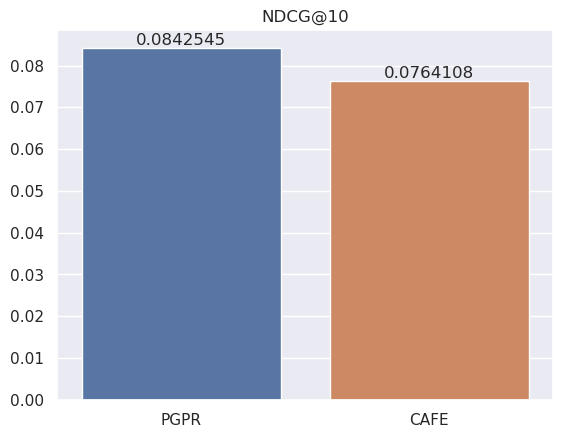

In [24]:
plt.figure()
ax = sns.barplot(x=["PGPR", "CAFE"], y=[0.08425451474999626,0.07641083248013784])
plt.title("NDCG@10")
for i in ax.containers:
    ax.bar_label(i,)

Text(0.5, 1.0, 'Adapted PGPR')

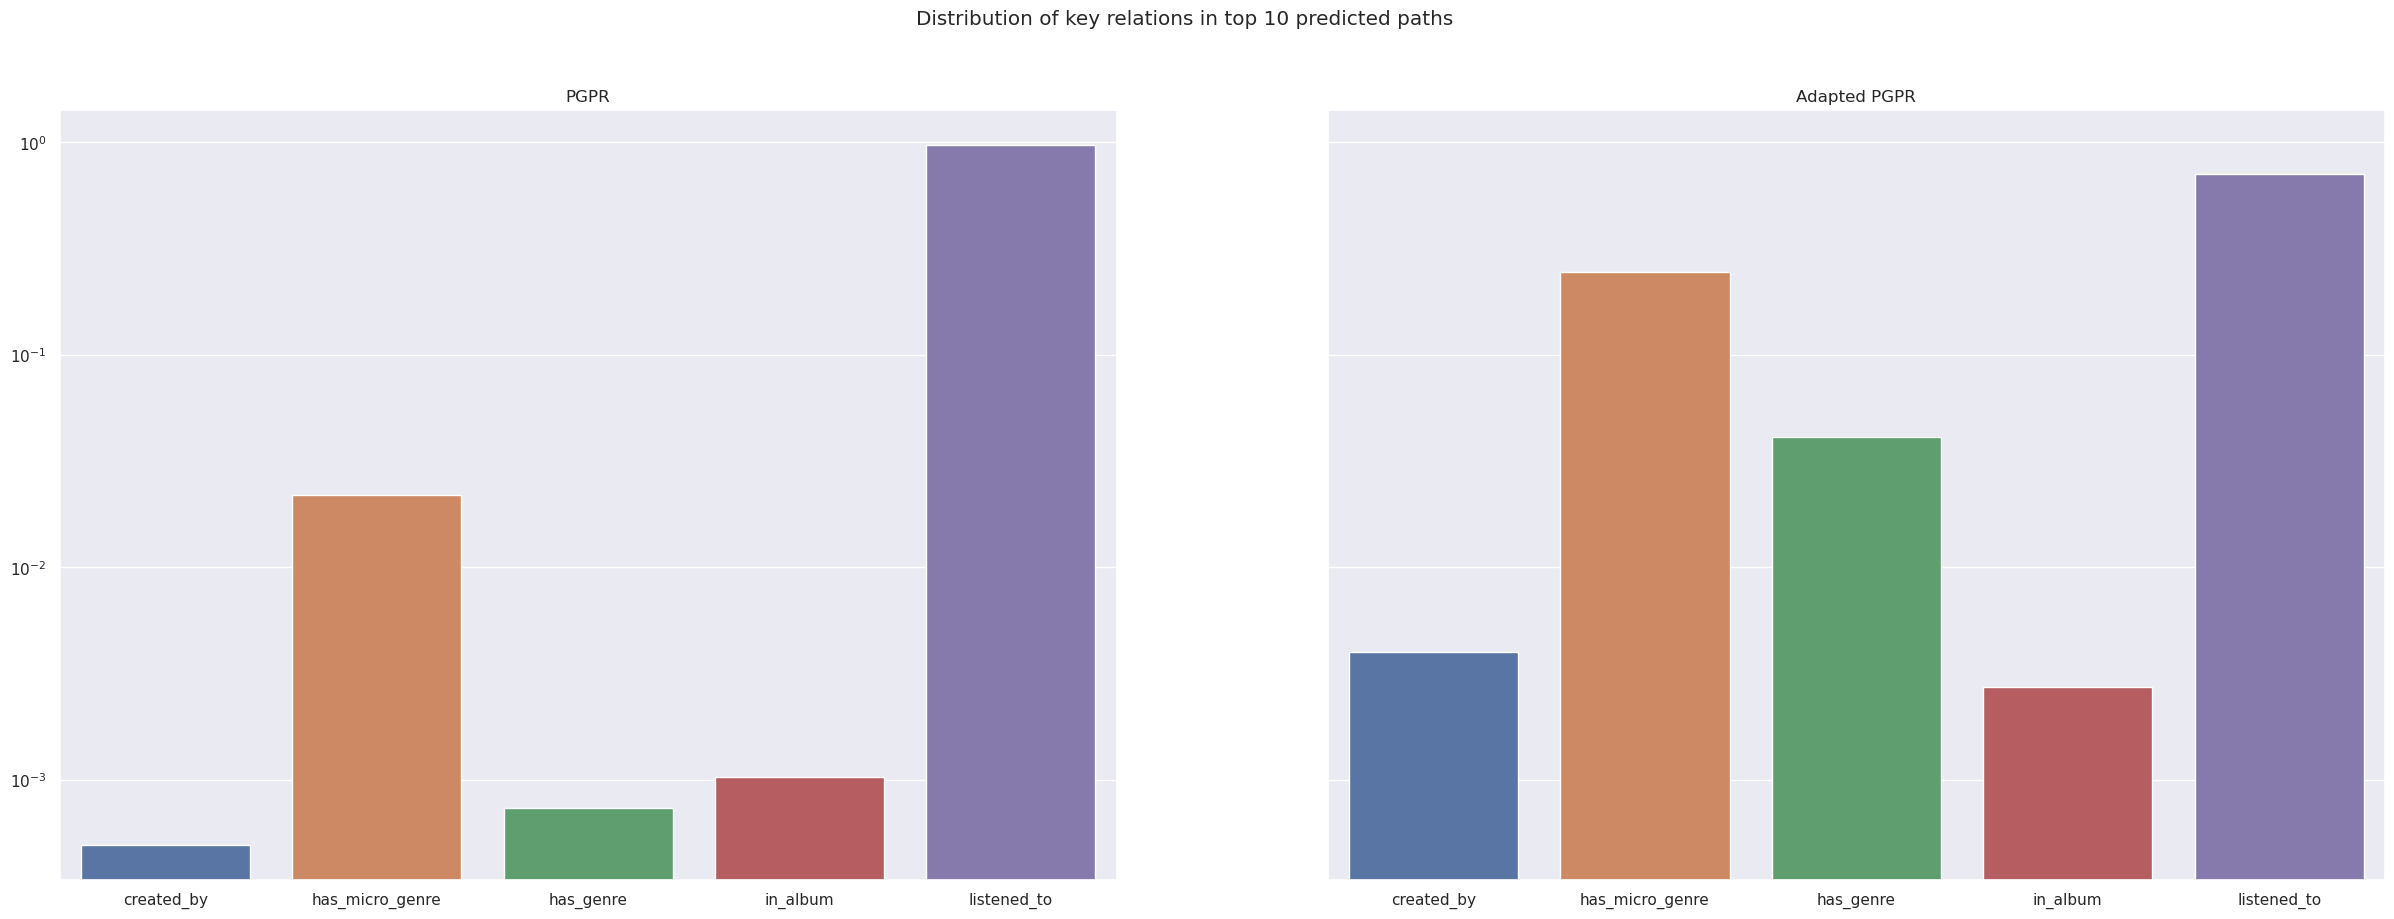

In [25]:
fig, ax = plt.subplots(1,2,figsize=(30,10), sharey='row')

fig.suptitle("Distribution of key relations in top 10 predicted paths (log scale)")
g = sns.barplot(ax=ax[0], x=all_relations, y=[relation_counts["pgpr_medium_entropy"][k] for k in all_relations])
g.set_yscale("log")
ax[0].set_title("PGPR")

fig.suptitle("Distribution of key relations in top 10 predicted paths")
g = sns.barplot(ax=ax[1], x=all_relations, y=[relation_counts["pgpr_rel_entropy"][k] for k in all_relations])
g.set_yscale("log")
ax[1].set_title("Adapted PGPR")

Text(0.5, 1.0, 'Adapted PGPR')

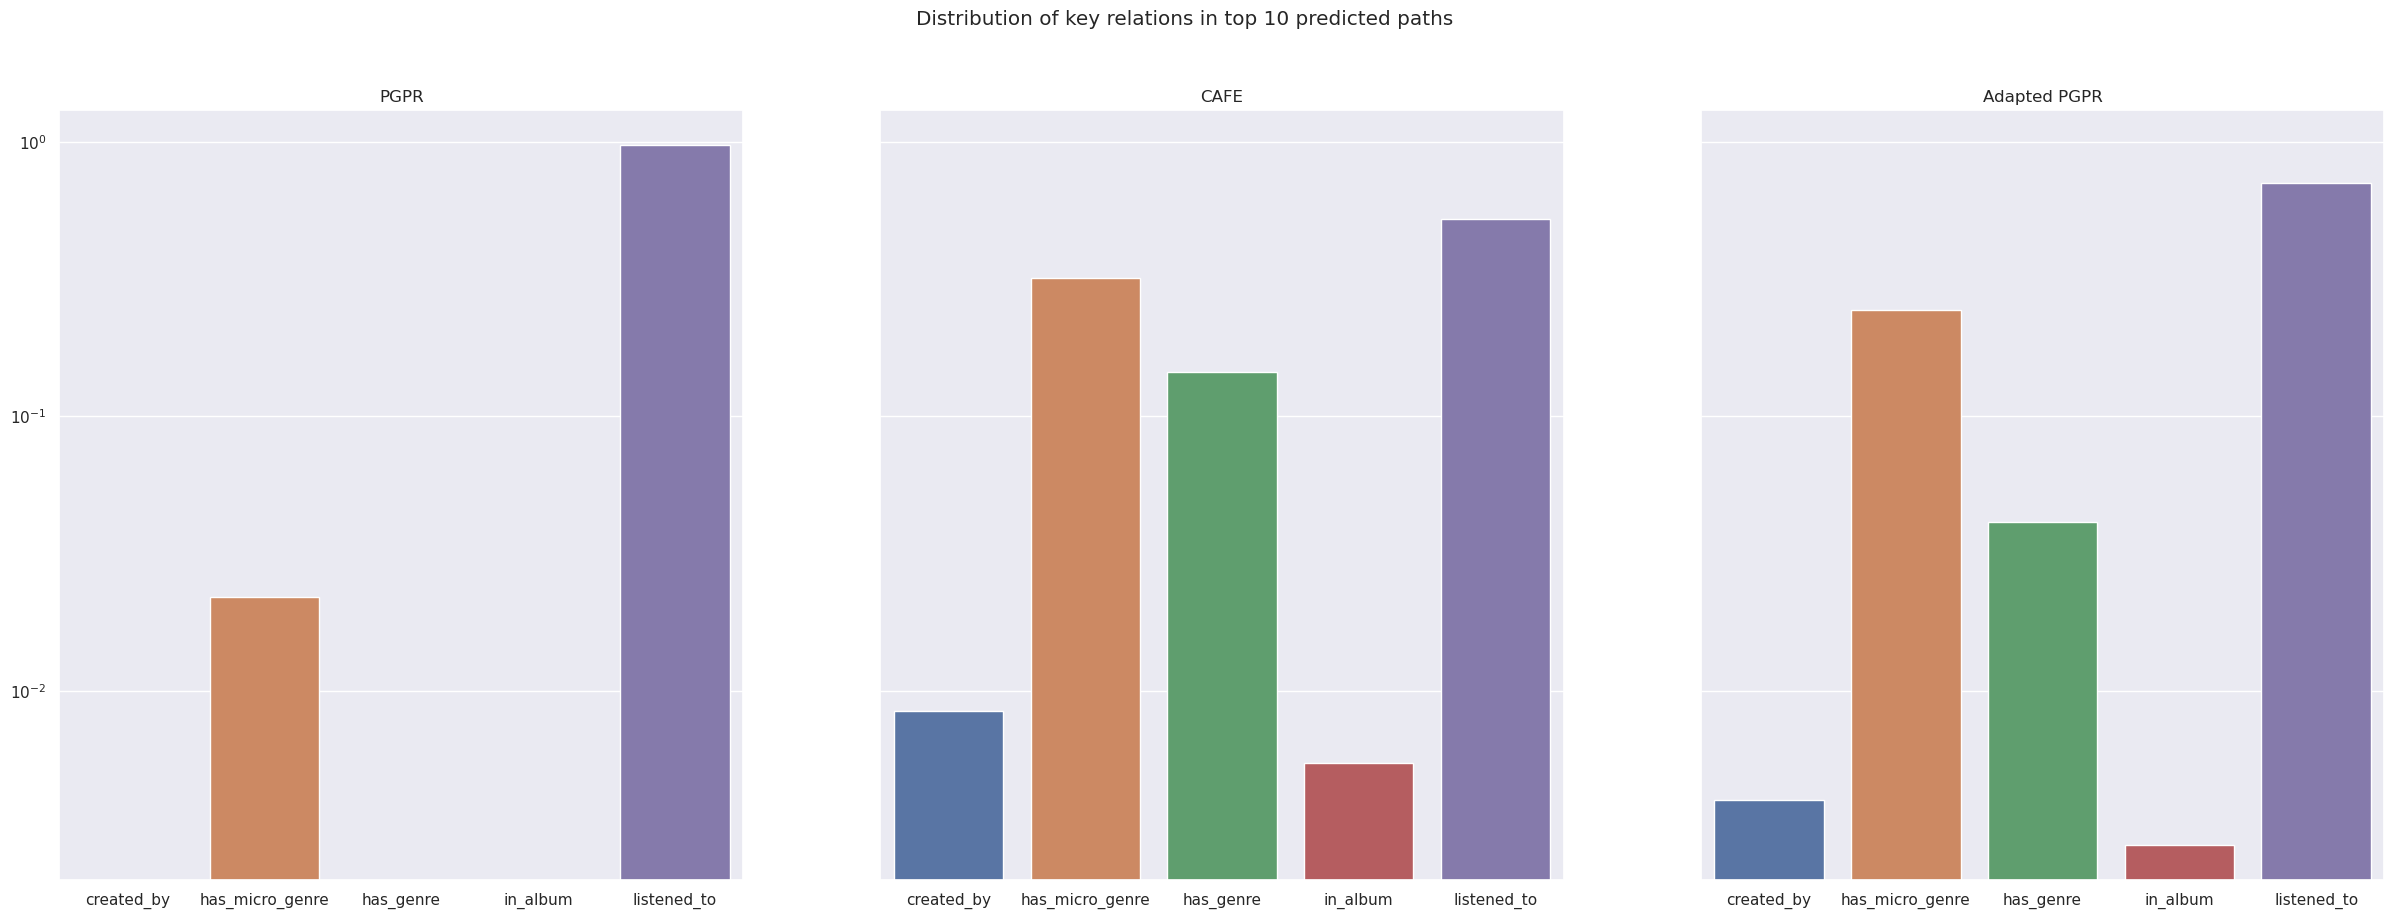

In [26]:
fig, ax = plt.subplots(1,3,figsize=(30,10), sharey='row')

fig.suptitle("Distribution of key relations in top 10 predicted paths (log scale)")
g = sns.barplot(ax=ax[0], x=all_relations, y=[relation_counts["pgpr_medium_entropy"][k] for k in all_relations])
g.set_yscale("log")
ax[0].set_title("PGPR")


g = sns.barplot(ax=ax[1], x=all_relations, y=[relation_counts["cafe"][k] for k in all_relations])
g.set_yscale("log")
ax[1].set_title("CAFE")

fig.suptitle("Distribution of key relations in top 10 predicted paths")
g = sns.barplot(ax=ax[2], x=all_relations, y=[relation_counts["pgpr_rel_entropy"][k] for k in all_relations])
g.set_yscale("log")
ax[2].set_title("Adapted PGPR")

## Divide users into age bins

A common choice of age bins is the following
0-17 (Children and adolescents)
18-34 (young adults)
35-49 (Middle aged adults)
50-64 (middle aged to adults)
65-79 (Older adults)
80+ (Elderly)

In [27]:
age_bins = [
    {
        "name": "Children and dolescents",
        "min": 0,
        "max": 17
    },
    {
        "name": "Young adults",
        "min": 18,
        "max": 34
    },
    {
        "name": "Middle aged adults",
        "min": 35,
        "max": 49
    },
    {
        "name": "Middle aged to older adults",
        "min": 50,
        "max": 64
    },
    {
        "name": "Older adults",
        "min": 65,
        "max": 79
    },
    {
        "name": "Elderly",
        "min": 80,
        "max": 100
    }
]

In [28]:
gender_bins = [
    {
        "name": "male",
        "gender": "m"
    },
    {
        "name": "female",
        "gender": "f"
    }
]

In [29]:
users = pd.read_csv('data/lfm/cleaned/users.tsv', sep='\t')
users.head()

,user_id,country,age,gender,creation_time
0,2,UK,35,m,2002-10-29 01:00:00
1,14,UK,48,m,2003-02-18 21:44:13
2,15,US,28,m,2003-02-24 03:30:33
3,36,UK,29,m,2003-03-27 12:17:12
4,42,RU,30,m,2003-04-10 01:07:48


In [30]:
user_id_mapping = pd.read_csv('data/lfm/preprocessed/users.txt', sep="\t")
user_id_mapping.head()

,new_id,raw_dataset_id
0,0,2
1,1,14
2,2,15
3,3,36
4,4,42


In [31]:
# Map the user ids to the internal ids used in the paths
users.user_id = users.user_id.apply(lambda id: user_id_mapping[user_id_mapping.raw_dataset_id == id].new_id.to_numpy()[0])

In [32]:
users.head()

,user_id,country,age,gender,creation_time
0,0,UK,35,m,2002-10-29 01:00:00
1,1,UK,48,m,2003-02-18 21:44:13
2,2,US,28,m,2003-02-24 03:30:33
3,3,UK,29,m,2003-03-27 12:17:12
4,4,RU,30,m,2003-04-10 01:07:48


In [54]:
np.random.choice(age_bins[1]["user_ids"])
users[users.user_id == 6915]

,user_id,country,age,gender,creation_time
6915,6915,US,24,m,2010-01-07 02:58:28


In [55]:
topk_paths["pgpr_medium_entropy"][6915]

[(169679,
  ['self_loop',
   'user',
   '6915',
   'listened_to',
   'product',
   '83645',
   'listened_to',
   'user',
   '7911',
   'listened_to',
   'product',
   '169679']),
 (170585,
  ['self_loop',
   'user',
   '6915',
   'listened_to',
   'product',
   '83645',
   'listened_to',
   'user',
   '8784',
   'listened_to',
   'product',
   '170585']),
 (171479,
  ['self_loop',
   'user',
   '6915',
   'listened_to',
   'product',
   '2156',
   'listened_to',
   'user',
   '9335',
   'listened_to',
   'product',
   '171479']),
 (171435,
  ['self_loop',
   'user',
   '6915',
   'listened_to',
   'product',
   '85436',
   'listened_to',
   'user',
   '3965',
   'listened_to',
   'product',
   '171435']),
 (171411,
  ['self_loop',
   'user',
   '6915',
   'listened_to',
   'product',
   '171459',
   'listened_to',
   'user',
   '4635',
   'listened_to',
   'product',
   '171411']),
 (169533,
  ['self_loop',
   'user',
   '6915',
   'listened_to',
   'product',
   '22804',
   'listened_

In [53]:
user_id_mapping[user_id_mapping.new_id == 6915]

,new_id,raw_dataset_id
6915,6915,43763


In [33]:
for age_bin in age_bins:
    age_bin["user_ids"] = users[(users.age >= age_bin["min"]) & (users.age <= age_bin["max"])].user_id.to_numpy()
    age_bin["total_count"] = len(age_bin["user_ids"])
    age_bin["total_train_item_count"] = 0
    age_bin["total_test_item_count"] = 0
    for user in age_bin["user_ids"]:
        age_bin["total_train_item_count"] = age_bin["total_train_item_count"] + len(train_labels[pgpr][user])
        age_bin["total_test_item_count"] = age_bin["total_test_item_count"] + len(test_labels[pgpr][user])

In [34]:
for gender_bin in gender_bins:
    gender_bin["user_ids"] = users[users.gender == gender_bin["gender"]].user_id.to_numpy()
    gender_bin["total_count"] = len(gender_bin["user_ids"])
    gender_bin["total_train_item_count"] = 0
    gender_bin["total_test_item_count"] = 0
    for user in gender_bin["user_ids"]:
        gender_bin["total_train_item_count"] = gender_bin["total_train_item_count"] + len(train_labels[pgpr][user])
        gender_bin["total_test_item_count"] = gender_bin["total_test_item_count"] + len(test_labels[pgpr][user])

6915

In [35]:
gender_bins

[{'name': 'male',
  'gender': 'm',
  'user_ids': array([   0,    1,    2, ..., 9449, 9451, 9452]),
  'total_count': 7679,
  'total_train_item_count': 3307565,
  'total_test_item_count': 830761},
 {'name': 'female',
  'gender': 'f',
  'user_ids': array([   5,    7,   20, ..., 9450, 9453, 9454]),
  'total_count': 1776,
  'total_train_item_count': 633954,
  'total_test_item_count': 159346}]

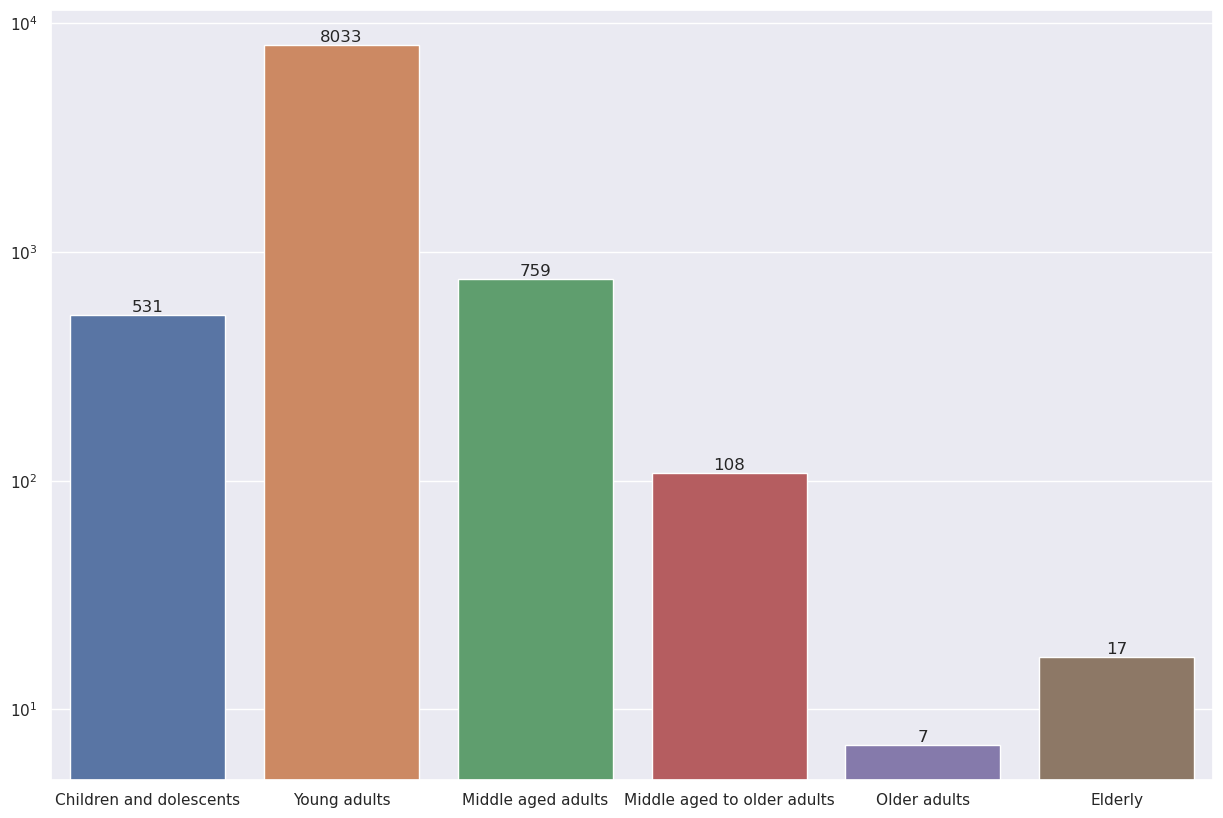

In [36]:
plt.figure(figsize=(15,10))
g = sns.barplot(x=[age_bin["name"] for age_bin in age_bins], y=[age_bin["total_count"] for age_bin in age_bins])
g.set_yscale("log")
for i in g.containers:
    g.bar_label(i,)
    

<Axes: >

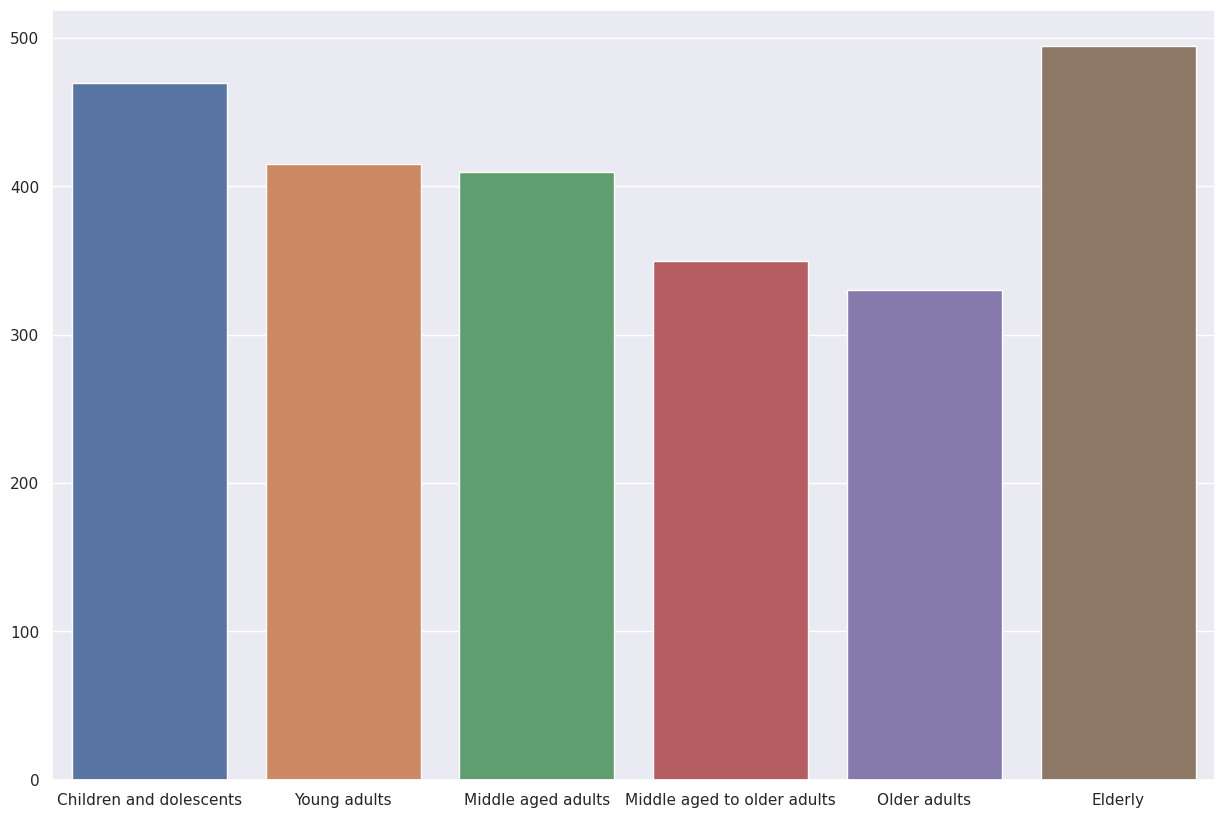

In [37]:
plt.figure(figsize=(15,10))
sns.barplot(x=[age_bin["name"] for age_bin in age_bins], y=[age_bin["total_train_item_count"]/age_bin["total_count"] for age_bin in age_bins])

<Axes: >

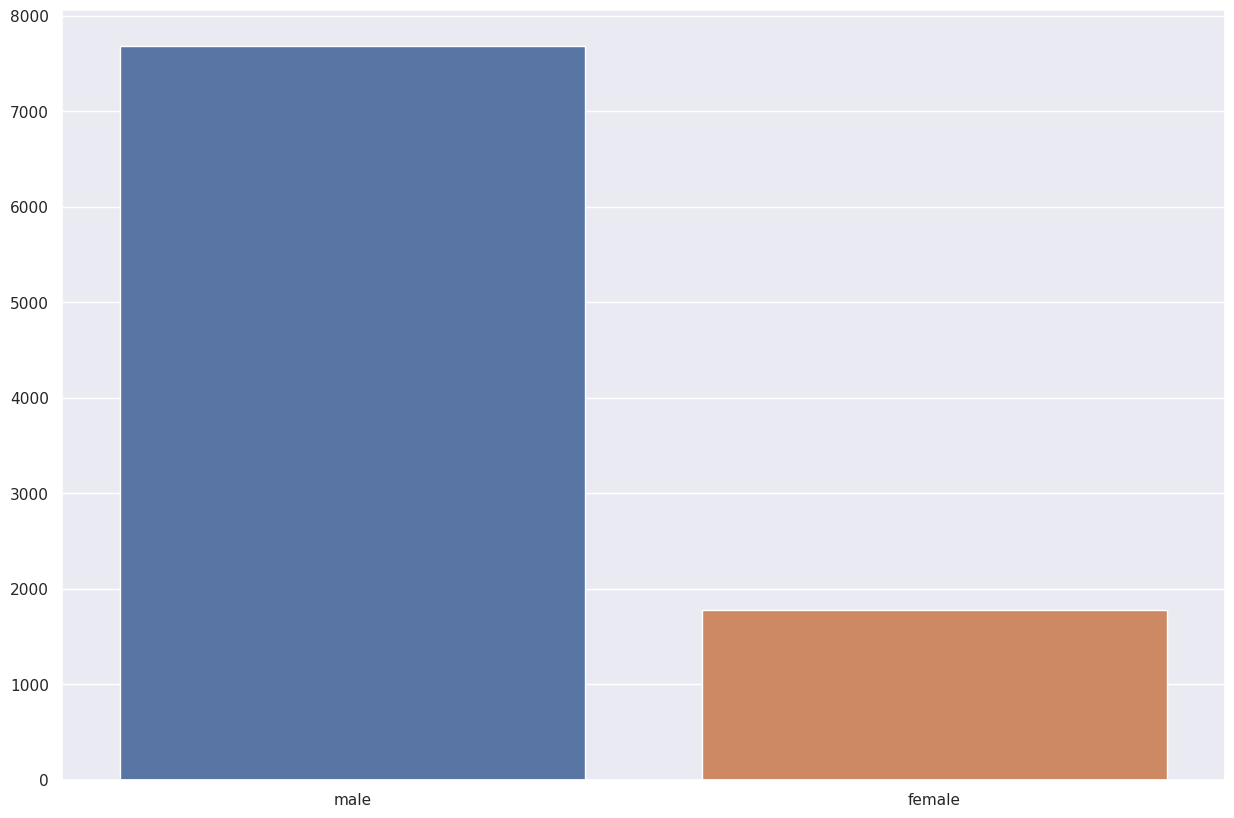

In [38]:
plt.figure(figsize=(15,10))
sns.barplot(x=[gender_bin["name"] for gender_bin in gender_bins], y=[gender_bin["total_count"] for gender_bin in gender_bins])

<Axes: >

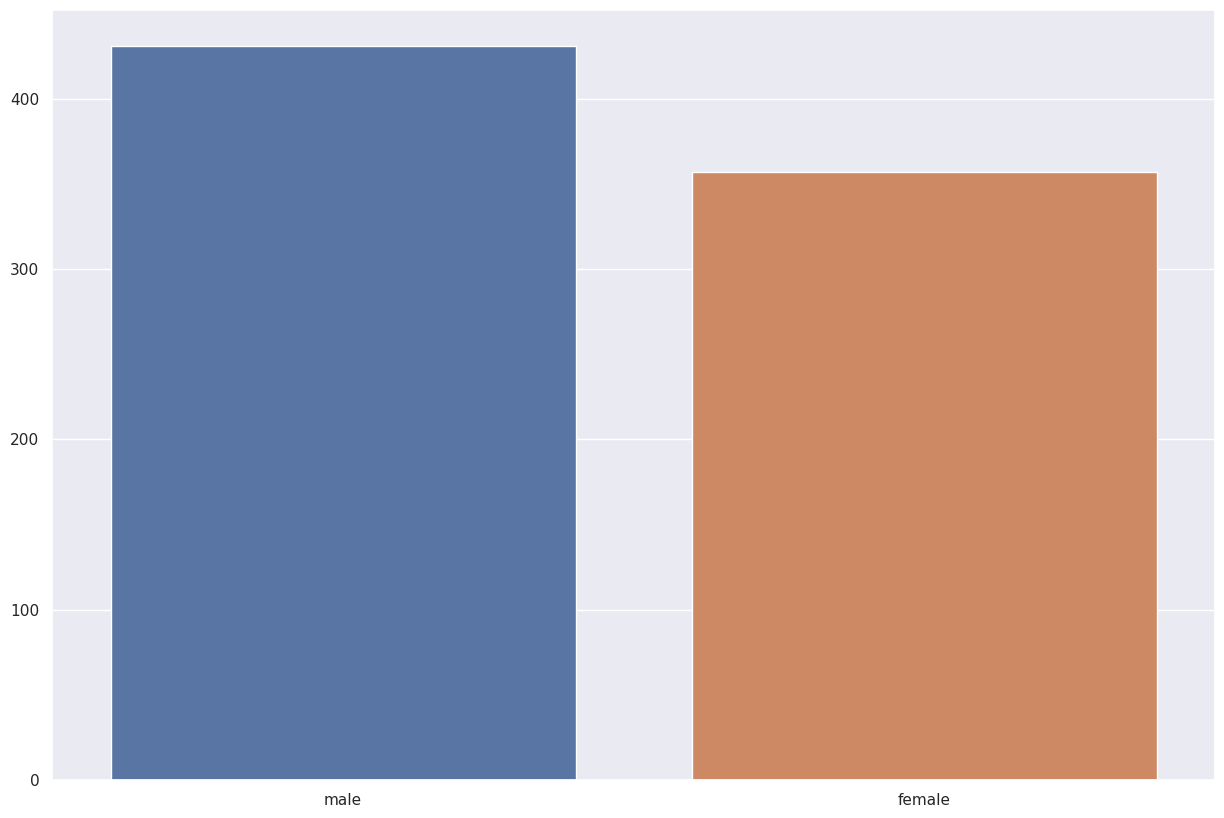

In [39]:
plt.figure(figsize=(15,10))
sns.barplot(x=[gender_bin["name"] for gender_bin in gender_bins], y=[gender_bin["total_train_item_count"]/gender_bin["total_count"] for gender_bin in gender_bins])

### Calculate metrics for age bins

In [40]:
topk_paths.keys()

dict_keys(['pgpr_no_entropy', 'pgpr_low_entropy', 'pgpr_medium_entropy', 'pgpr_high_entropy', 'pgpr_rel_entropy', 'cafe'])

In [41]:
age_metrics = {}
for model in models:
    for flavor in pgpr_flavors if model == pgpr else [""]:
        age_metrics[model + (("_" + flavor) if flavor != "" else "")] = {}
        print("Evaluating ", model, flavor)
        for age_bin in age_bins:
            print("Age bin:", age_bin["name"])
            bin_paths = {k: topk_paths[model + (("_" + flavor) if flavor != "" else "")][k] for k in age_bin["user_ids"]}
            metrics_for_top_k(bin_paths, model)
            age_metrics[model + (("_" + flavor) if flavor != "" else "")][age_bin["name"]] = {}
            age_metrics[model + (("_" + flavor) if flavor != "" else "")][age_bin["name"]]["relation_counts"] = count_relations(user_topk=bin_paths, model=model)
            ndcg, precision, recall = metrics_for_top_k(user_topk=bin_paths, model=model)
            age_metrics[model + (("_" + flavor) if flavor != "" else "")][age_bin["name"]]["ndcg"] = ndcg
            age_metrics[model + (("_" + flavor) if flavor != "" else "")][age_bin["name"]]["precision"] = precision
            age_metrics[model + (("_" + flavor) if flavor != "" else "")][age_bin["name"]]["recall"] = recall

age_metrics

Evaluating  cafe 
Age bin: Children and dolescents
Overall NDGC: 0.10677986922448081, Precision: 0.028436911487758943, Recall: 0.0028350931468206987
Overall NDGC: 0.10677986922448081, Precision: 0.028436911487758943, Recall: 0.0028350931468206987
Age bin: Young adults
Overall NDGC: 0.07546729209164947, Precision: 0.01944479024025893, Recall: 0.0030351568342967625
Overall NDGC: 0.07546729209164947, Precision: 0.01944479024025893, Recall: 0.0030351568342967625
Age bin: Middle aged adults
Overall NDGC: 0.06884776827880326, Precision: 0.01673254281949934, Recall: 0.003422856752897002
Overall NDGC: 0.06884776827880326, Precision: 0.01673254281949934, Recall: 0.003422856752897002
Age bin: Middle aged to older adults
Overall NDGC: 0.036406440921157, Precision: 0.011111111111111113, Recall: 0.0021707065263029315
Overall NDGC: 0.036406440921157, Precision: 0.011111111111111113, Recall: 0.0021707065263029315
Age bin: Older adults
Overall NDGC: 0.14285714285714285, Precision: 0.014285714285714287

{'cafe': {'Children and dolescents': {'relation_counts': {'created_by': 0.006663826861566976,
    'has_micro_genre': 0.33054210384719024,
    'has_genre': 0.15724449227274087,
    'in_album': 0.0021134128478761246,
    'listened_to': 0.5034361641706282},
   'ndcg': 0.10677986922448081,
   'precision': 0.028436911487758943,
   'recall': 0.0028350931468206987},
  'Young adults': {'relation_counts': {'created_by': 0.008577860373578085,
    'has_micro_genre': 0.31850975835790324,
    'has_genre': 0.14420545013723352,
    'in_album': 0.005466883628840592,
    'listened_to': 0.5232400475024761},
   'ndcg': 0.07546729209164947,
   'precision': 0.01944479024025893,
   'recall': 0.0030351568342967625},
  'Middle aged adults': {'relation_counts': {'created_by': 0.009160967856620027,
    'has_micro_genre': 0.3136499571282197,
    'has_genre': 0.14862967145575834,
    'in_album': 0.006433904259991217,
    'listened_to': 0.5221254992994113},
   'ndcg': 0.06884776827880326,
   'precision': 0.0167325

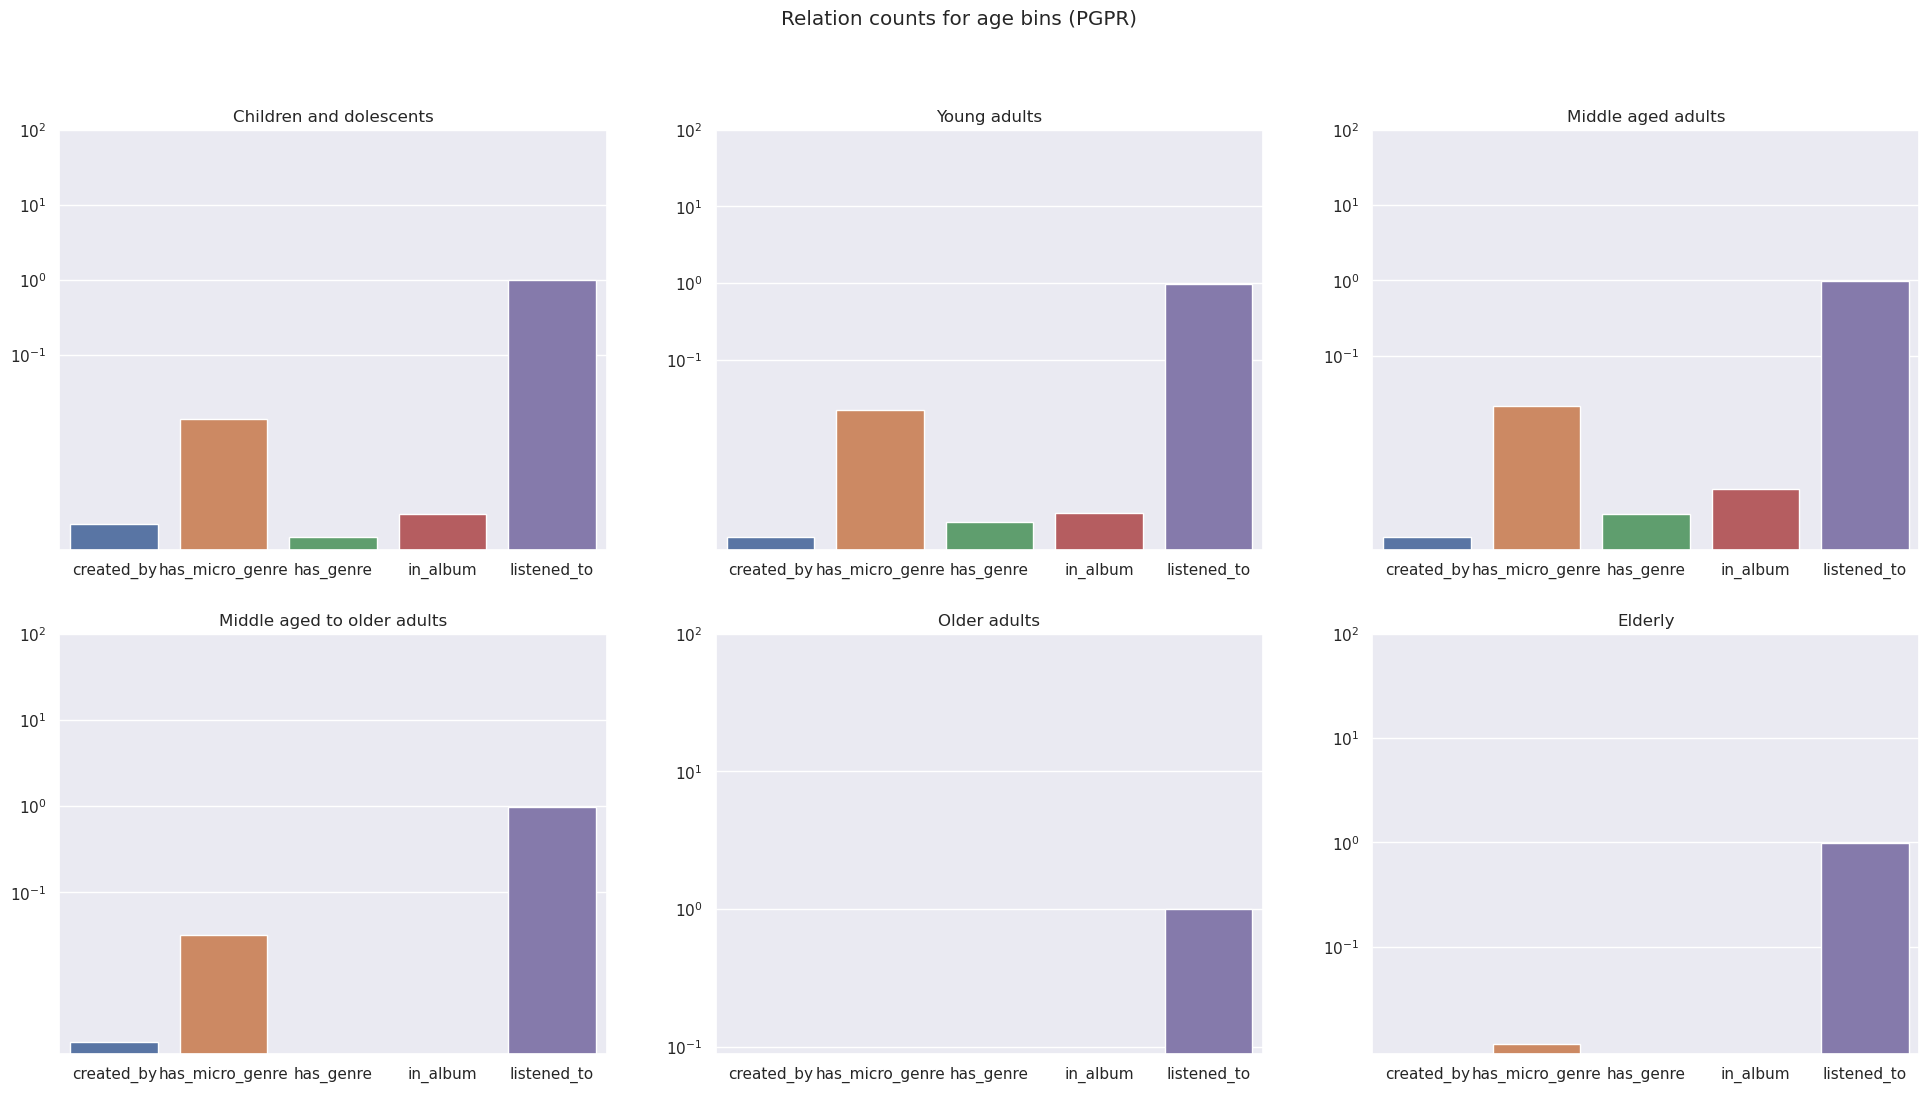

In [42]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))
fig.suptitle("Relation counts for age bins (PGPR)")
model_name = pgpr + "_medium_entropy"
for age_bin_name, ax in zip(age_metrics[model_name].keys(), axs.ravel()):
    # filter df for ticker and plot on specified axes
    g = sns.barplot(ax=ax, x=all_relations, y=[age_metrics[model_name][age_bin_name]["relation_counts"][k] if k in age_metrics[model_name][age_bin_name]["relation_counts"] else 0 for k in all_relations])
    g.set_yscale("log")
    ax.set_title(age_bin_name)
    ax.set_yticks([0.1,1,10, 100]) 


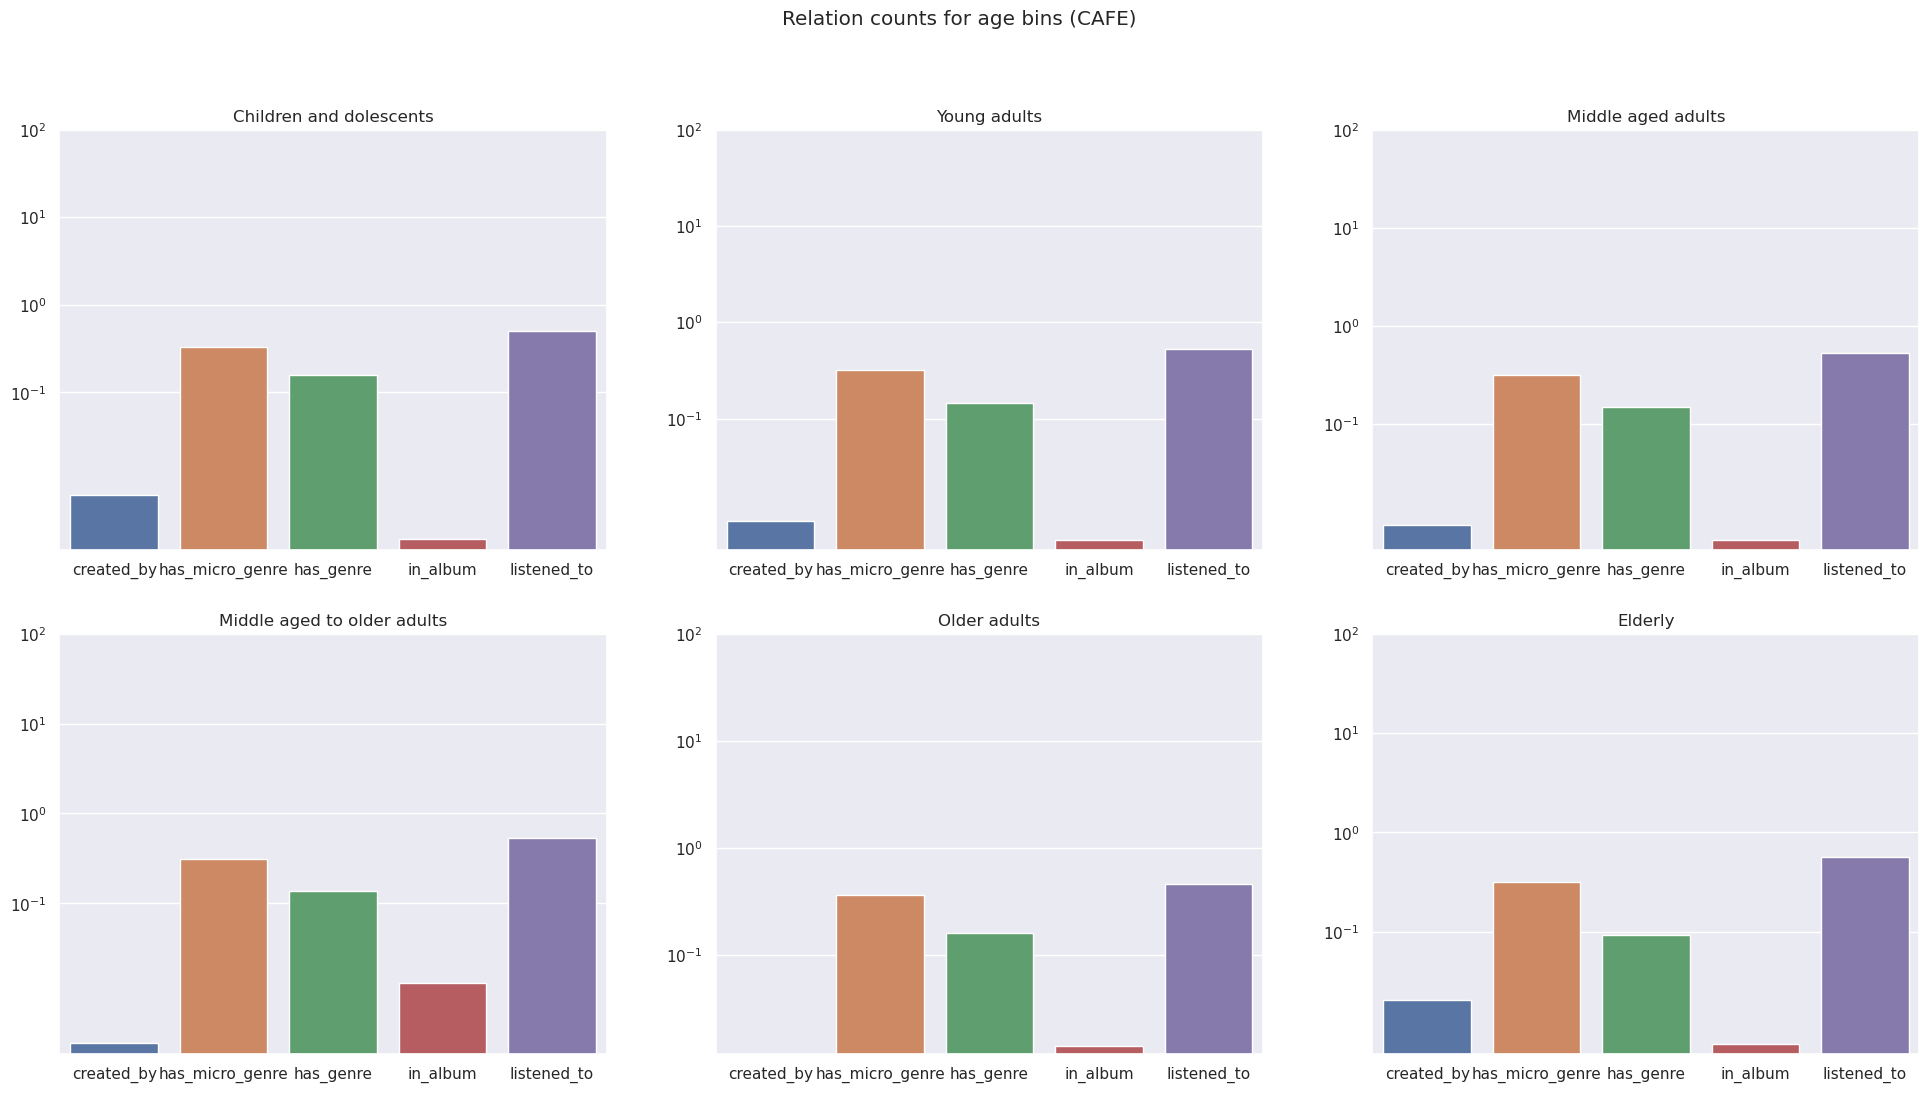

In [43]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))
fig.suptitle("Relation counts for age bins (CAFE)")
all_relations = ["created_by", "has_micro_genre", "has_genre", "in_album", "listened_to"]
model_name = cafe
for age_bin_name, ax in zip(age_metrics[model_name].keys(), axs.ravel()):
    # filter df for ticker and plot on specified axes
    g = sns.barplot(ax=ax, x=all_relations, y=[age_metrics[model_name][age_bin_name]["relation_counts"][k] if k in age_metrics[model_name][age_bin_name]["relation_counts"] else 0 for k in all_relations])
    g.set_yscale("log")
    ax.set_title(age_bin_name)
    ax.set_yticks([0.1,1,10, 100]) 


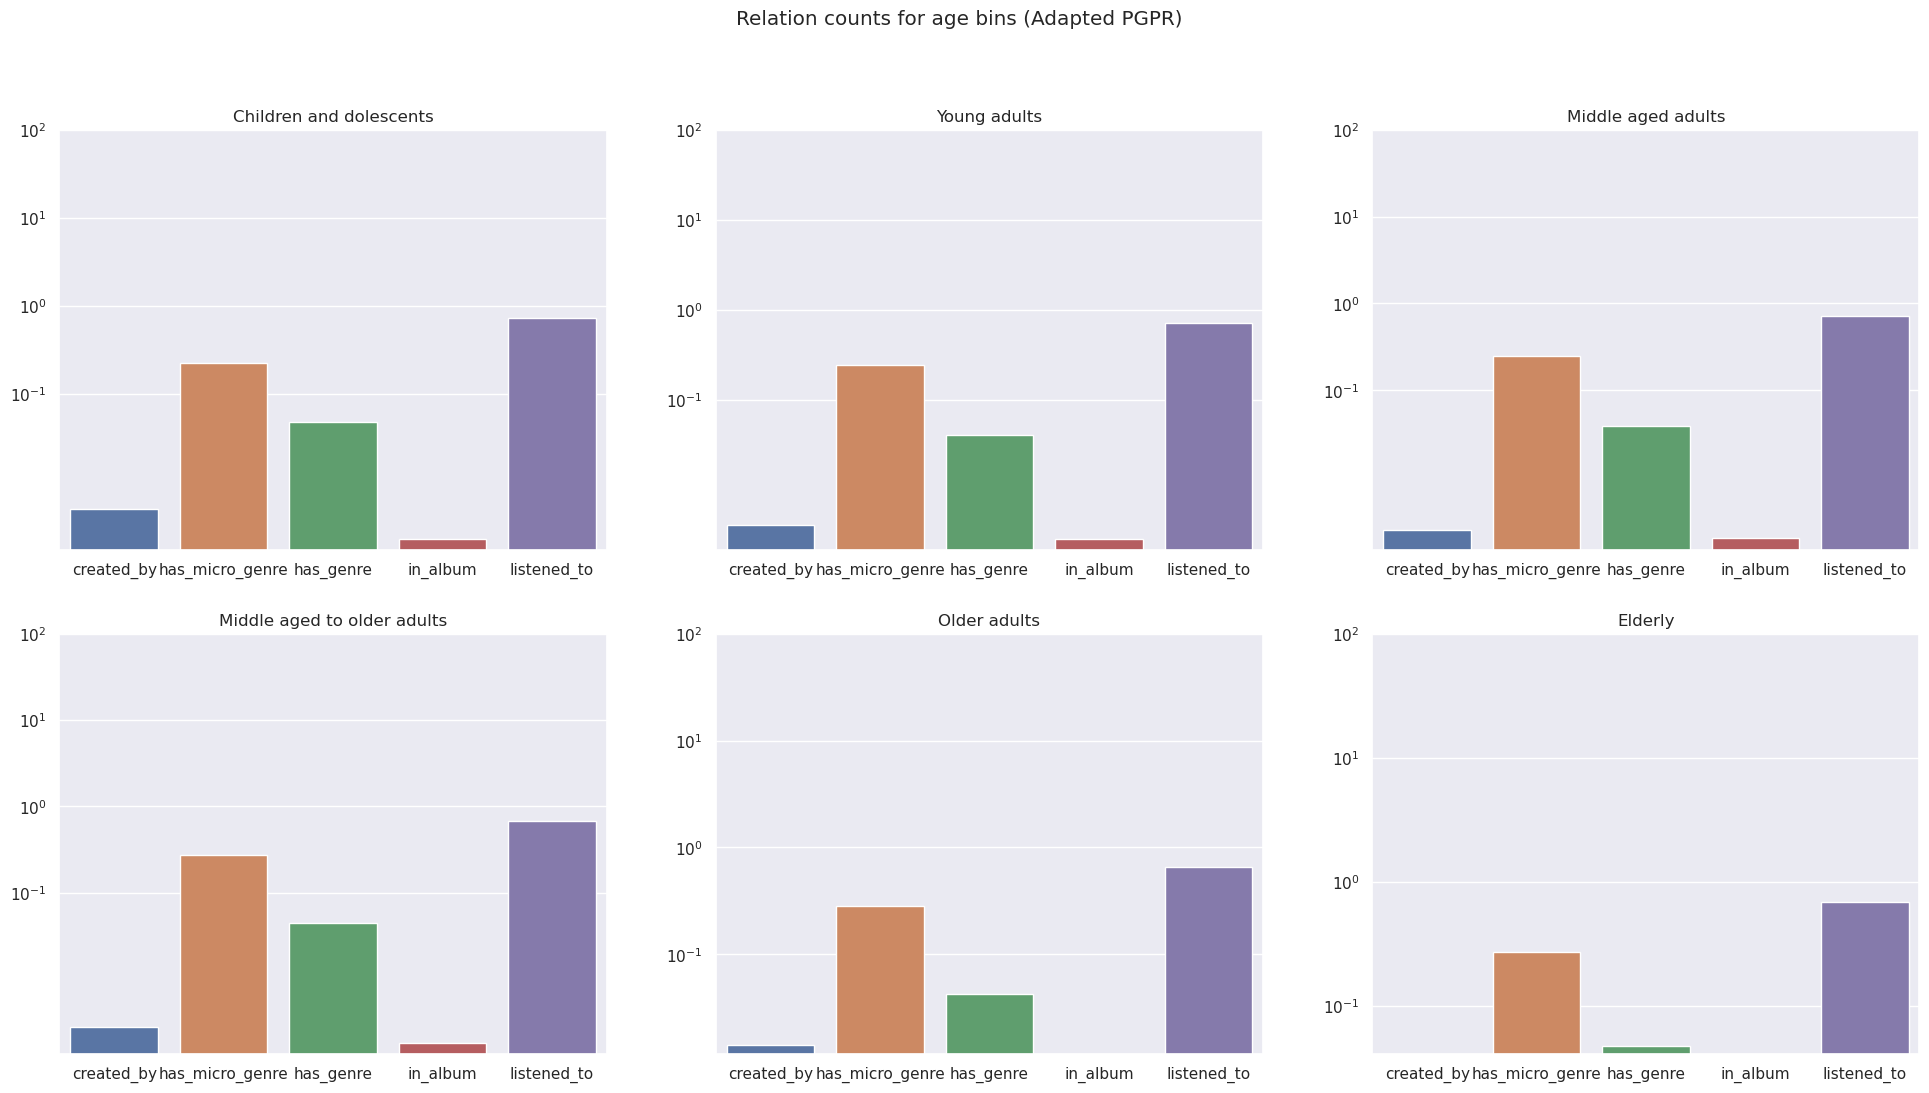

In [44]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))
fig.suptitle("Relation counts for age bins (Adapted PGPR)")
model_name = pgpr + "_rel_entropy"
for age_bin_name, ax in zip(age_metrics[model_name].keys(), axs.ravel()):
    # filter df for ticker and plot on specified axes
    g = sns.barplot(ax=ax, x=all_relations, y=[age_metrics[model_name][age_bin_name]["relation_counts"][k] if k in age_metrics[model_name][age_bin_name]["relation_counts"] else 0 for k in all_relations])
    g.set_yscale("log")
    ax.set_title(age_bin_name)
    ax.set_yticks([0.1,1,10, 100]) 


In [45]:
ylims = [[0,0.2],[0,0.035],[0,0.0035]]

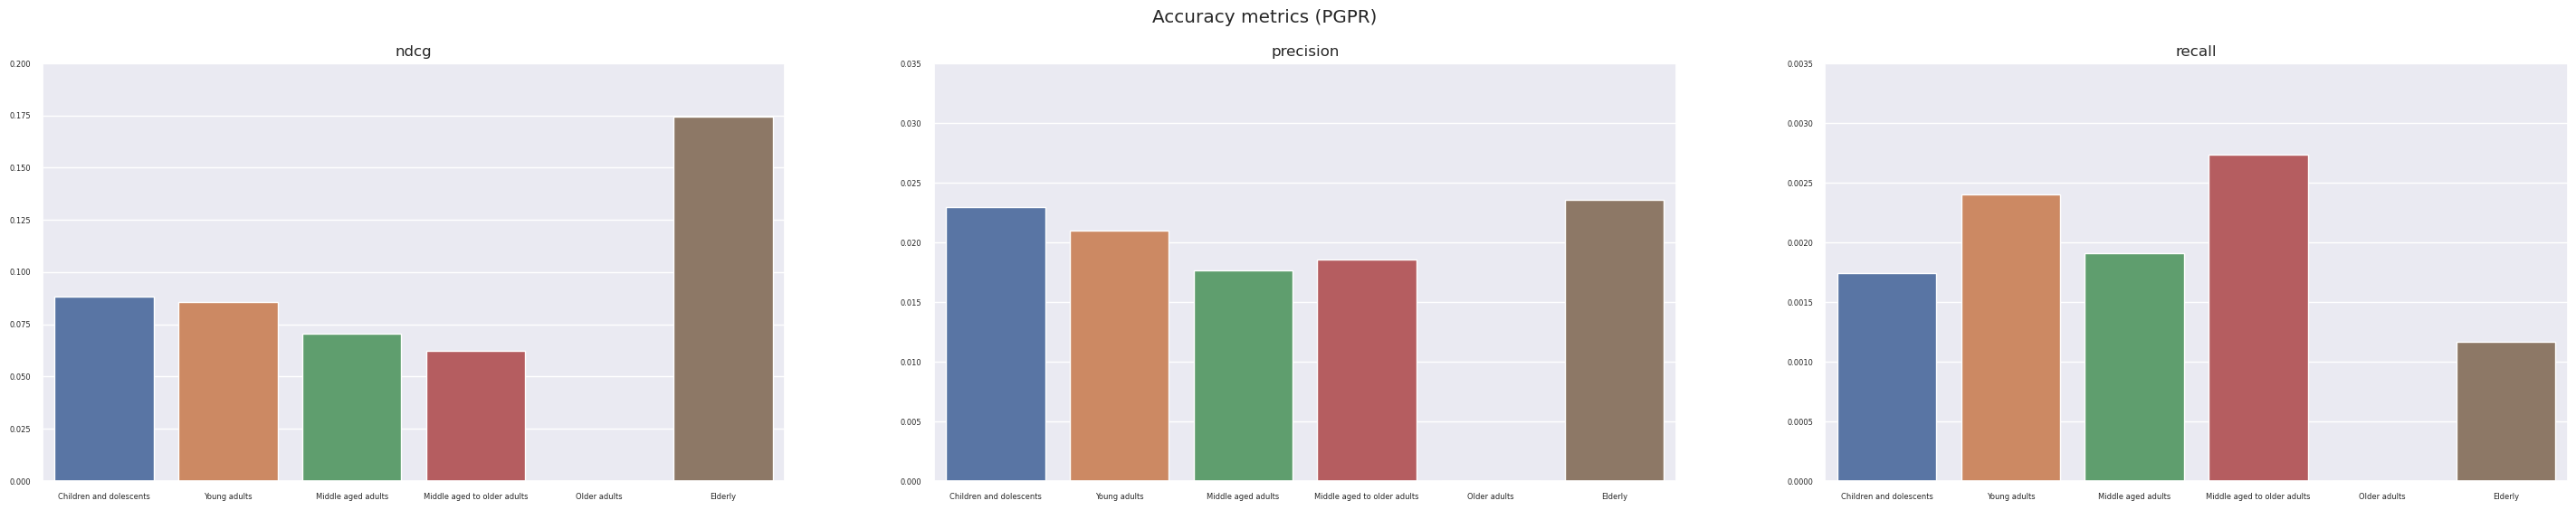

In [46]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(36, 6))
fig.suptitle("Accuracy metrics (PGPR)")
model_name = pgpr + "_medium_entropy"
for idx, (metric_name, ax) in enumerate(zip(["ndcg", "precision", "recall"], axs.ravel())):
    # filter df for ticker and plot on specified axes
    g = sns.barplot(ax=ax, x=[age_bin["name"] for age_bin in age_bins], y=[age_metrics[model_name][age_bin["name"]][metric_name] for age_bin in age_bins])
    ax.set_title(metric_name)
    g.tick_params(labelsize=6)
    ax.set_ylim(ylims[idx])


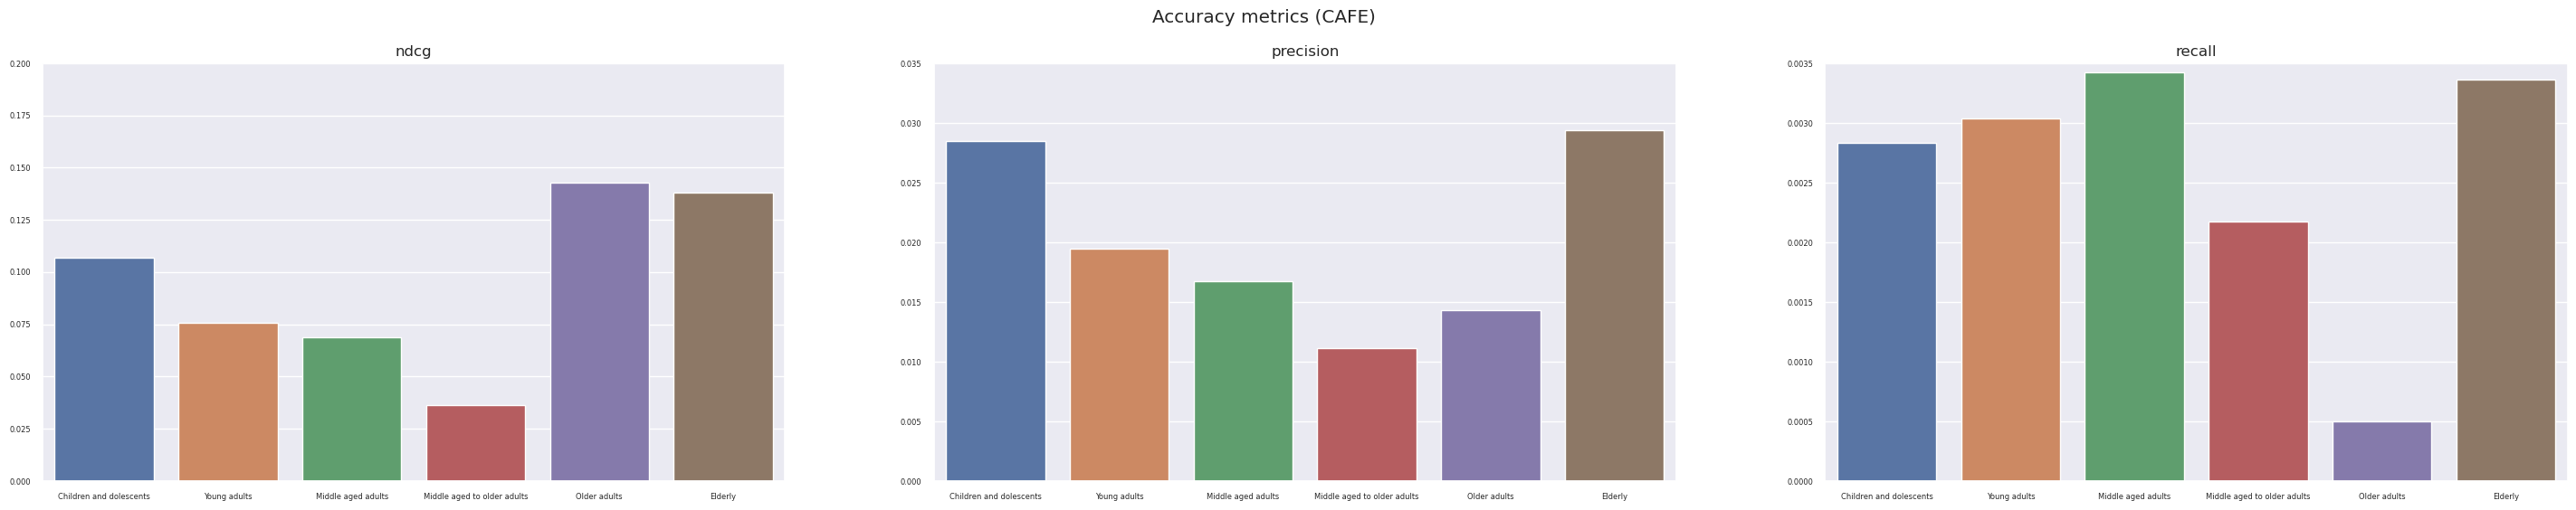

In [47]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(36, 6))
fig.suptitle("Accuracy metrics (CAFE)")
model_name = cafe
for idx, (metric_name, ax) in enumerate(zip(["ndcg", "precision", "recall"], axs.ravel())):
    # filter df for ticker and plot on specified axes
    g = sns.barplot(ax=ax, x=[age_bin["name"] for age_bin in age_bins], y=[age_metrics[model_name][age_bin["name"]][metric_name] for age_bin in age_bins])
    ax.set_title(metric_name)
    g.tick_params(labelsize=6)
    ax.set_ylim(ylims[idx])


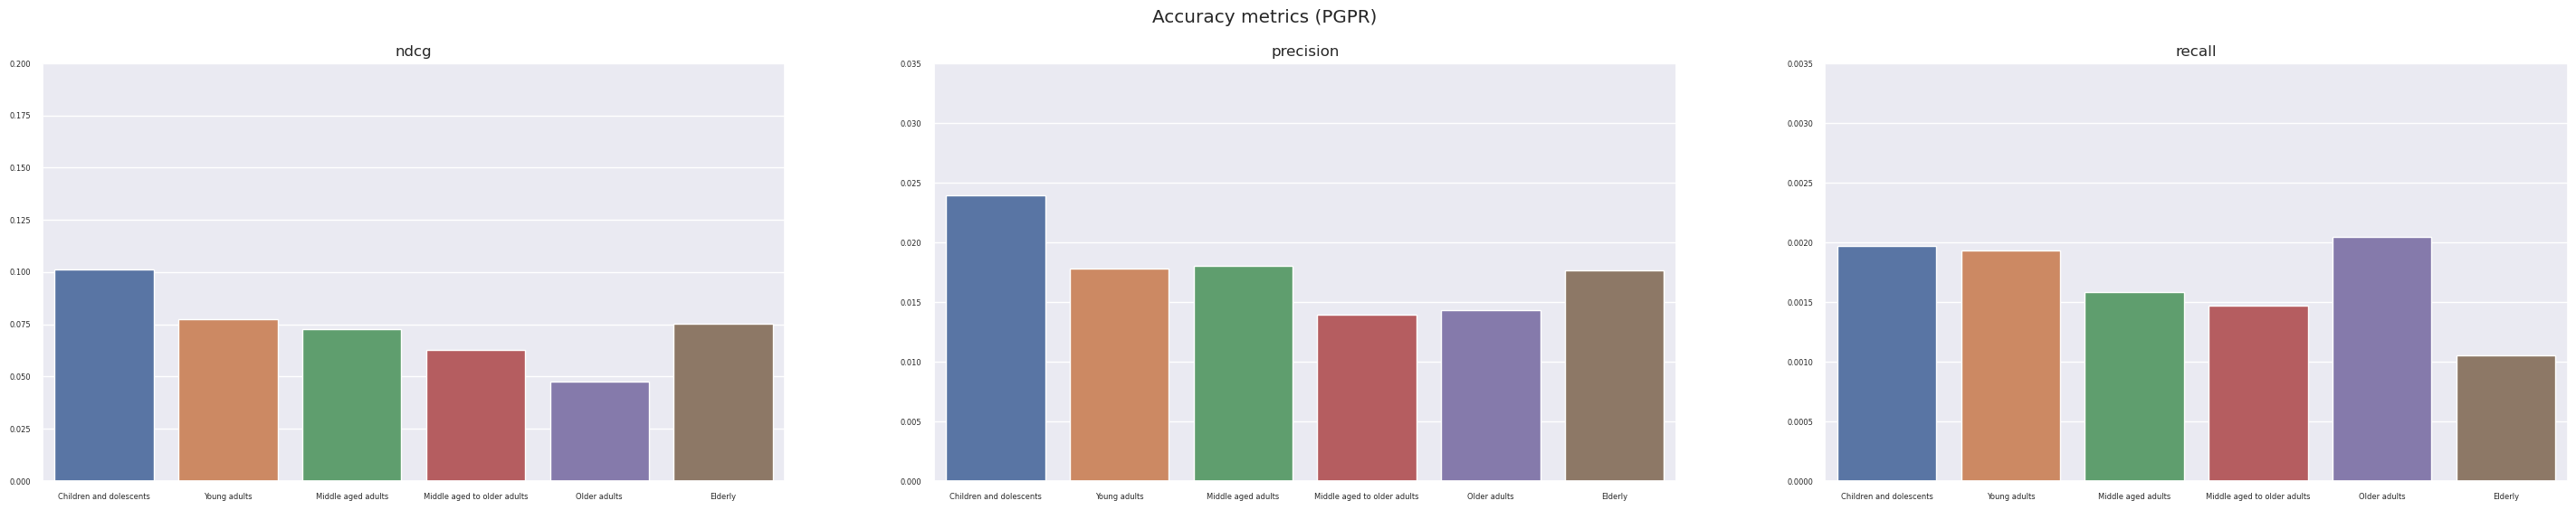

In [48]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(36, 6))
fig.suptitle("Accuracy metrics (PGPR)")
model_name = pgpr + "_rel_entropy"
for idx, (metric_name, ax) in enumerate(zip(["ndcg", "precision", "recall"], axs.ravel())):
    # filter df for ticker and plot on specified axes
    g = sns.barplot(ax=ax, x=[age_bin["name"] for age_bin in age_bins], y=[age_metrics[model_name][age_bin["name"]][metric_name] for age_bin in age_bins])
    ax.set_title(metric_name)
    g.tick_params(labelsize=6)
    ax.set_ylim(ylims[idx])



### Calculate metrics for gender bins

In [49]:
gender_metrics = {}
for model in models:
    gender_metrics[model] = {}
    print("Evaluating ", model)
    for gender_bin in gender_bins:
        print("Age bin:", gender_bin["name"])
        bin_paths = {k: topk_paths[model][k] for k in gender_bin["user_ids"]}
        metrics_for_top_k(bin_paths, model)
        gender_metrics[model][gender_bin["name"]] = {}
        gender_metrics[model][gender_bin["name"]]["relation_counts"] = count_relations(user_topk=bin_paths, model=model)
        ndcg, precision, recall = metrics_for_top_k(user_topk=bin_paths, model=model)
        gender_metrics[model][gender_bin["name"]]["ndcg"] = ndcg
        gender_metrics[model][gender_bin["name"]]["precision"] = precision
        gender_metrics[model][gender_bin["name"]]["recall"] = recall

gender_metrics

Evaluating  cafe
Age bin: male
Overall NDGC: 0.07865742329254233, Precision: 0.0204714155488996, Recall: 0.0030509429452568273
Overall NDGC: 0.07865742329254233, Precision: 0.0204714155488996, Recall: 0.0030509429452568273
Age bin: female
Overall NDGC: 0.06669711015555783, Precision: 0.016103603603603602, Recall: 0.003013325622457999
Overall NDGC: 0.06669711015555783, Precision: 0.016103603603603602, Recall: 0.003013325622457999
Evaluating  pgpr
Age bin: male


KeyError: 'pgpr'

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))
fig.suptitle("Relation counts for gender bins (PGPR)")
all_relations = ["created_by", "has_micro_genre", "has_genre", "in_album", "listened_to"]
model_name = pgpr
for gender_bin_name, ax in zip(gender_metrics[model_name].keys(), axs.ravel()):
    # filter df for ticker and plot on specified axes
    g = sns.barplot(ax=ax, x=all_relations, y=[gender_metrics[model_name][gender_bin_name]["relation_counts"][k] if k in gender_metrics[model_name][gender_bin_name]["relation_counts"] else 0 for k in all_relations])
    g.set_yscale("log")
    ax.set_title(gender_bin_name)
    ax.set_yticks([0.1,1,10, 100]) 


In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))
fig.suptitle("Relation counts for gender bins (CAFE)")
all_relations = ["created_by", "has_micro_genre", "has_genre", "in_album", "listened_to"]
model_name = cafe
for gender_bin_name, ax in zip(gender_metrics[model_name].keys(), axs.ravel()):
    # filter df for ticker and plot on specified axes
    g = sns.barplot(ax=ax, x=all_relations, y=[gender_metrics[model_name][gender_bin_name]["relation_counts"][k] if k in gender_metrics[model_name][gender_bin_name]["relation_counts"] else 0 for k in all_relations])
    g.set_yscale("log")
    ax.set_title(gender_bin_name)
    ax.set_yticks([0.1,1,10, 100]) 


In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(36, 6))
fig.suptitle("Relation counts for age bins (PGPR)")
model_name = pgpr
for metric_name, ax in zip(["ndcg", "precision", "recall"], axs.ravel()):
    # filter df for ticker and plot on specified axes
    g = sns.barplot(ax=ax, x=[gender_bin["name"] for gender_bin in gender_bins], y=[gender_metrics[model_name][gender_bin["name"]][metric_name] for gender_bin in gender_bins])
    ax.set_title(metric_name)
    g.tick_params(labelsize=6)


In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(36, 6))
fig.suptitle("Relation counts for age bins (CAFE)")
model_name = cafe
for metric_name, ax in zip(["ndcg", "precision", "recall"], axs.ravel()):
    # filter df for ticker and plot on specified axes
    g = sns.barplot(ax=ax, x=[gender_bin["name"] for gender_bin in gender_bins], y=[gender_metrics[model_name][gender_bin["name"]][metric_name] for gender_bin in gender_bins])
    ax.set_title(metric_name)
    g.tick_params(labelsize=6)


In [108]:
topk_paths["pgpr_medium_entropy"][3298]

[(171411,
  ['self_loop',
   'user',
   '3298',
   'listened_to',
   'product',
   '96774',
   'listened_to',
   'user',
   '5688',
   'listened_to',
   'product',
   '171411']),
 (169533,
  ['self_loop',
   'user',
   '3298',
   'listened_to',
   'product',
   '29248',
   'listened_to',
   'user',
   '8323',
   'listened_to',
   'product',
   '169533']),
 (169679,
  ['self_loop',
   'user',
   '3298',
   'listened_to',
   'product',
   '170839',
   'listened_to',
   'user',
   '5952',
   'listened_to',
   'product',
   '169679']),
 (24091,
  ['self_loop',
   'user',
   '3298',
   'listened_to',
   'product',
   '30305',
   'listened_to',
   'user',
   '9254',
   'listened_to',
   'product',
   '24091']),
 (171677,
  ['self_loop',
   'user',
   '3298',
   'listened_to',
   'product',
   '171676',
   'listened_to',
   'user',
   '3696',
   'listened_to',
   'product',
   '171677']),
 (30086,
  ['self_loop',
   'user',
   '3298',
   'listened_to',
   'product',
   '26143',
   'has_micro_

In [57]:
e_map = pd.read_csv('data/lfm/preprocessed/e_map.txt', sep='\t')

In [58]:
tracks = pd.read_csv('data/lfm/cleaned/tracks.tsv', sep='\t')

In [117]:
e_map[e_map.entity_id == 119820].entity_url.values[0]

't32941844'

In [122]:
tracks[tracks.track_id == int('t32941844'[1:])].track.values[0]

'Reggaetón lento (Bailemos)'

In [104]:
contains = False
while not contains:
    uid = np.random.choice(gender_bins[1]["user_ids"], 1)[0]
    rels = [a[1][6] for a in topk_paths["pgpr_rel_entropy"][uid]]
    contains = 'created_by' in rels or 'in_album' in rels


In [106]:
[a[1][6] for a in topk_paths["pgpr_rel_entropy"][3298]]

['has_micro_genre',
 'created_by',
 'has_micro_genre',
 'created_by',
 'has_genre',
 'listened_to',
 'has_micro_genre',
 'listened_to',
 'listened_to',
 'has_micro_genre']

In [123]:
entity2name = entity2plain_text("lfm", "pgpr")

In [154]:
entity2name['product'][96774]

'Nem o Mar (PÃ´de Levar)'

In [112]:
 topk_paths["pgpr_rel_entropy"][3298]

[(76034,
  ['self_loop',
   'user',
   '3298',
   'listened_to',
   'product',
   '119820',
   'has_micro_genre',
   'micro_genre',
   '1447',
   'has_micro_genre',
   'product',
   '76034']),
 (113427,
  ['self_loop',
   'user',
   '3298',
   'listened_to',
   'product',
   '3215',
   'created_by',
   'artist',
   '7754',
   'created_by',
   'product',
   '113427']),
 (142263,
  ['self_loop',
   'user',
   '3298',
   'listened_to',
   'product',
   '119816',
   'has_micro_genre',
   'micro_genre',
   '646',
   'has_micro_genre',
   'product',
   '142263']),
 (11836,
  ['self_loop',
   'user',
   '3298',
   'listened_to',
   'product',
   '119816',
   'created_by',
   'artist',
   '1941',
   'created_by',
   'product',
   '11836']),
 (10862,
  ['self_loop',
   'user',
   '3298',
   'listened_to',
   'product',
   '96774',
   'has_genre',
   'genre',
   '287',
   'has_genre',
   'product',
   '10862']),
 (103404,
  ['self_loop',
   'user',
   '3298',
   'listened_to',
   'product',
   '

In [142]:
entity2name['product'][171676]

'Ã¡gua de beber'

In [132]:
topk_paths["pgpr_medium_entropy"][3298]

[(171411,
  ['self_loop',
   'user',
   '3298',
   'listened_to',
   'product',
   '96774',
   'listened_to',
   'user',
   '5688',
   'listened_to',
   'product',
   '171411']),
 (169533,
  ['self_loop',
   'user',
   '3298',
   'listened_to',
   'product',
   '29248',
   'listened_to',
   'user',
   '8323',
   'listened_to',
   'product',
   '169533']),
 (169679,
  ['self_loop',
   'user',
   '3298',
   'listened_to',
   'product',
   '170839',
   'listened_to',
   'user',
   '5952',
   'listened_to',
   'product',
   '169679']),
 (24091,
  ['self_loop',
   'user',
   '3298',
   'listened_to',
   'product',
   '30305',
   'listened_to',
   'user',
   '9254',
   'listened_to',
   'product',
   '24091']),
 (171677,
  ['self_loop',
   'user',
   '3298',
   'listened_to',
   'product',
   '171676',
   'listened_to',
   'user',
   '3696',
   'listened_to',
   'product',
   '171677']),
 (30086,
  ['self_loop',
   'user',
   '3298',
   'listened_to',
   'product',
   '26143',
   'has_micro_

In [109]:
[a[1][6] for a in topk_paths["pgpr_medium_entropy"][3298]]

['listened_to',
 'listened_to',
 'listened_to',
 'listened_to',
 'listened_to',
 'has_micro_genre',
 'listened_to',
 'listened_to',
 'listened_to',
 'listened_to']

In [102]:
np.random.choice(gender_bins[1]["user_ids"], 1)


array([5851])

In [107]:
users[users.user_id == 3298]

,user_id,country,age,gender,creation_time
3298,3298,BR,26,f,2007-08-01 17:00:43


In [110]:
user_id_mapping[user_id_mapping.new_id == 3298]

,new_id,raw_dataset_id
3298,3298,14065
